In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from math import ceil
from itertools import zip_longest
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 44)


In [4]:
coffee = pd.read_csv('../data/coffee_fix_clean.csv')

In [5]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   slug                   2277 non-null   object 
 1   all_text               2277 non-null   object 
 2   rating                 2277 non-null   int64  
 3   roaster                2277 non-null   object 
 4   name                   2277 non-null   object 
 5   roaster_city           2277 non-null   object 
 6   origin                 2277 non-null   object 
 7   roast                  2277 non-null   object 
 8   est_price              2277 non-null   object 
 9   review_date            2277 non-null   object 
 10  agtron                 2277 non-null   object 
 11  aroma                  2277 non-null   float64
 12  acid                   2277 non-null   float64
 13  body                   2277 non-null   float64
 14  flavor                 2277 non-null   float64
 15  afte

|Column|Data Types|Description|
|---|---|---|
|rating|int64|Overall Rating of Coffee|
|roaster|object|Roaster Name|
|roaster_country_state|object|State/Country of Roaster|
|roaster_country|object|Country of Roaster|
|name|object|Name of coffee bean|
|roaster_city|object|City of Roaster|
|origin|object|Coffee Bean Origin|
|origin_count|int64|Coffee Bean Origin count|
|origin_country|object|Coffee Bean Origin Country|
|est_price|object|Eatimated price in local currency|
|review_date|object|Date that review is posted|
|roast|object|Range from light to dark roast|
|agtron|object|Roast level of bean and after it is grinded|
|agtron_grounds|int64|Roast level of after it is grinded|
|agtron_bean|int64|Roast level of before it is grinded|
|aroma|float64|0-10 rating of coffee's aroma|
|acid|float64|0-10 rating of coffee's acidity|
|body|float64|0-10 rating of coffee's body|
|flavor|float64|0-10 rating of coffee's flavor|
|aftertaste|float64|0-10 rating of coffee's after taste|
|with_milk|float64|0-10 rating of coffee with milk|
|desc_1|object|Blind Assessment|
|desc_2|object|Information on coffee bean
|desc_3|object|Summary|



In [6]:
coffee = coffee.loc[:,['name','roaster','roaster_city','roaster_country_state','roaster_country','origin',
                       'origin_count','origin_country','review_date','est_price','rating','roast','agtron',
                       'agtron_grounds','agtron_bean','aroma','acid','body','flavor','aftertaste','with_milk',
                       'desc_1','desc_2','desc_3']]

In [7]:
def pie_chart(df, col, title):
    labels = [i for i in df[col].value_counts().index]
    df[col].value_counts().plot.pie(figsize=(8,8),
                                                 pctdistance=0.4,
                                                 startangle=90,
                                                 textprops={"color": "white"},
                                                 wedgeprops={"linewidth":0})
    plt.title(title, fontsize=20, pad=5)
    plt.ylabel("")
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop={"size":12, 
                                                                 "weight":"ultralight"})
    plt.show();


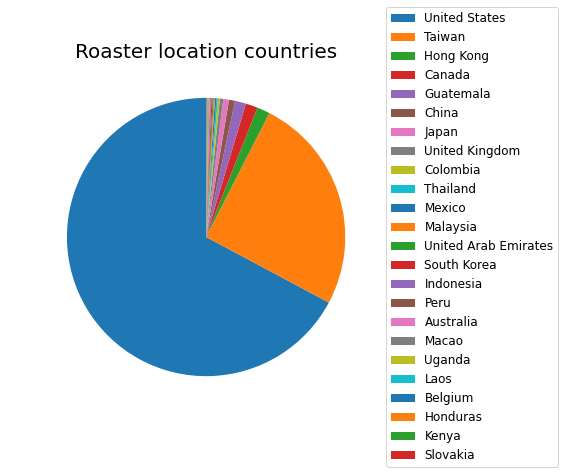

<Figure size 432x288 with 0 Axes>

In [8]:
pie_chart(coffee, "roaster_country", "Roaster location countries")
plt.savefig('../chart/roaster_country.png', bbox_inches='tight')

In [9]:
coffee.groupby(['roaster_country'])[['roaster']].count().sort_values(by='roaster',ascending=False)

,roaster
roaster_country,
United States,1530
Taiwan,576
Hong Kong,34
Canada,32
Guatemala,29
China,16
Japan,15
United Kingdom,9
Colombia,5


In [10]:
coffee_single = coffee[(coffee['origin_count'] == 1) & (coffee['origin_country'] != 'Not disclosed')]
coffee_single

,name,roaster,roaster_city,roaster_country_state,roaster_country,origin,origin_count,origin_country,review_date,est_price,...,agtron_bean,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3
2,Ethiopia Shakiso Mormora,Revel Coffee,Billings,Montana,United States,"Guji Zone, southern Ethiopia",1,Ethiopia,November 2017,$16.00/12 ounces,...,70,9.0,8.0,8.0,9.0,8.0,0.0,"Crisply sweet, cocoa-toned. Lemon blosso...",This coffee tied for the third-highest r...,"A gently spice-toned, floral- driven wet..."
3,Ethiopia Suke Quto,Roast House,Spokane,Washington,United States,"Guji Zone, Oromia Region, south-central ...",1,Ethiopia,November 2017,$19.00/16 ounces,...,79,8.0,8.0,9.0,9.0,8.0,0.0,"Delicate, sweetly spice-toned. Pink pepp...",This coffee tied for the third-highest r...,Lavender-like flowers and hints of zesty...
4,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Hamilton,Montana,United States,"Gedeb District, Gedeo Zone, southern Eth...",1,Ethiopia,November 2017,$16.50/12 ounces,...,70,9.0,9.0,9.0,9.0,8.0,0.0,"Deeply sweet, subtly pungent. Honey, pea...",Southern Ethiopia coffees like this one ...,A deeply and generously lush cup saved f...
5,Ethiopia Kayon Mountain,Red Rooster Coffee Roaster,Floyd,Virginia,United States,"Odo Shakiso District, Guji Zone, souther...",1,Ethiopia,November 2017,$17.49/12 ounces,...,92,9.0,8.0,9.0,9.0,8.0,0.0,"Delicate, richly and sweetly tart. Dried...",This coffee tied for the second-highest ...,"A lively and crisply sweet, fruit-forwar..."
6,Ethiopia Gelgelu Natural Organic,Willoughby's Coffee & Tea,Branford,Connecticut,United States,"Yirgacheffe growing region, southern Eth...",1,Ethiopia,November 2017,$17.99/16 ounces,...,75,9.0,8.0,9.0,9.0,8.0,0.0,"High-toned, floral. Dried apricot, magno...",This coffee tied for the second-highest ...,A deeply sweet natural-processed Ethiopi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,Finca Patzibir,El Gran Cafe,Antigua,Guatemala,Guatemala,"Lake Atitlán growing region, Guatemala",1,Guatemala,November 2022,$16.00/12 ounces,...,74,8.0,8.0,9.0,9.0,8.0,0.0,"Crisply sweet, nut-toned. Almond brittle...",Produced by Andres Fahsen of Finca Patzi...,"A quietly confident, sweetly nut-toned G..."
2273,Proyecto Aurora,El Gran Cafe,Antigua,Guatemala,Guatemala,"Antigua growing region, Guatemala",1,Guatemala,November 2022,$10.00/12 ounces,...,76,9.0,9.0,8.0,9.0,8.0,0.0,"Chocolaty, floral-framed. Cocoa nib, hon...",Produced at Beneficio La Esperanza from ...,"A deeply floral, richly chocolaty Guatem..."
2274,Finca El Potrero,El Gran Cafe,Antigua,Guatemala,Guatemala,"Antigua growing region, Guatemala",1,Guatemala,November 2022,$10.00/12 ounces,...,76,9.0,9.0,8.0,9.0,8.0,0.0,"High-toned, enticingly sweet. Black cher...",Produced by Josué Morales of Finca El P...,"A bright, balanced, juicy Guatemala cup ..."
2275,Chacayá Santiago Atitlán,El Gran Cafe,Antigua,Guatemala,Guatemala,"Lake Atitlán growing region, Guatemala",1,Guatemala,November 2022,$16.00/12 ounces,...,73,9.0,8.0,8.0,9.0,8.0,0.0,"Vibrantly sweet, subtly nuanced. Aprico...",Produced by smallholding farmers of Asoc...,"Balanced, bright, invigoratingly crisp, ..."


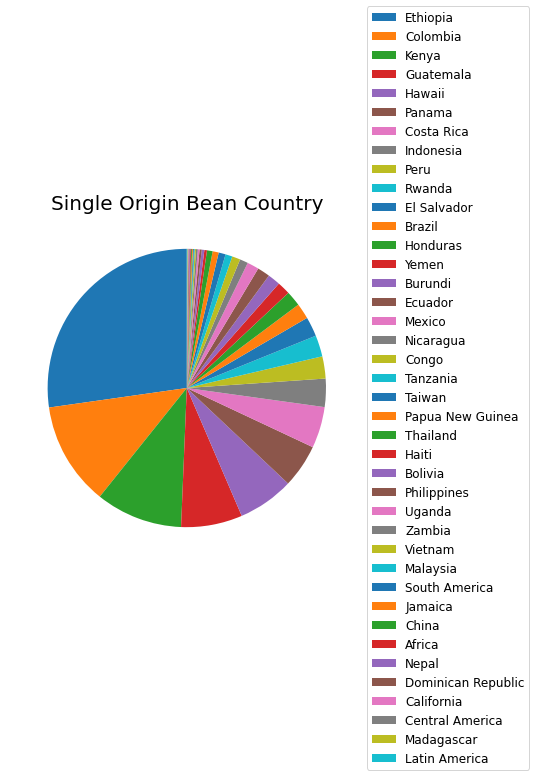

<Figure size 432x288 with 0 Axes>

In [11]:
pie_chart(coffee_single, "origin_country", "Single Origin Bean Country")
plt.savefig('../chart/origin_country.png', bbox_inches='tight')

In [12]:
coffee_single.groupby(['origin_country'])[['roaster']].count().sort_values(by='roaster',ascending=False)

,roaster
origin_country,
Ethiopia,540
Colombia,238
Kenya,200
Guatemala,141
Hawaii,129
Panama,100
Costa Rica,95
Indonesia,65
Peru,51


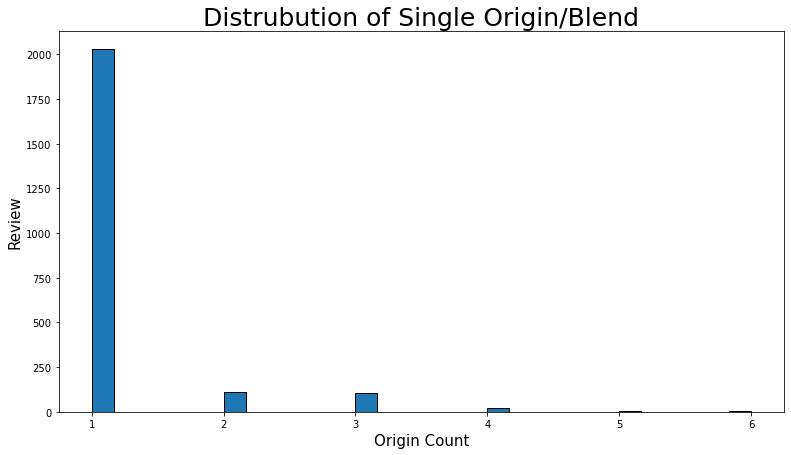

In [13]:
plt.figure(figsize=(13,7))
plt.hist([coffee['origin_count'],],
         bins=30, ec='k')

plt.title('Distrubution of Single Origin/Blend', fontsize=25)
# plt.legend(['Nike', 'Adidas'], fontsize=18);
plt.xlabel("Origin Count", fontsize=15)
plt.ylabel("Review", fontsize=15)
plt.savefig('../chart/origin_count2.png', bbox_inches='tight')

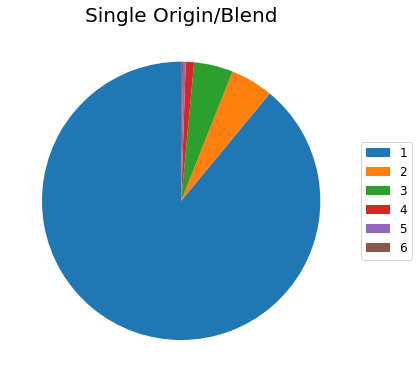

<Figure size 432x288 with 0 Axes>

In [14]:
pie_chart(coffee, "origin_count", "Single Origin/Blend")
plt.savefig('../chart/origin_count.png', bbox_inches='tight')

In [15]:
coffee.sort_values(by='rating', ascending = False)


,name,roaster,roaster_city,roaster_country_state,roaster_country,origin,origin_count,origin_country,review_date,est_price,...,agtron_bean,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3
670,Elida Estate Geisha Green-Tip Natural,Dragonfly Coffee Roasters,Boulder,Colorado,United States,"Boquete growing region, western Panama",1,Panama,October 2019,$100.00/21 grams,...,78,10.0,10.0,9.0,10.0,9.0,0.0,Vast yet intimate in its layered intrica...,This exceptional coffee was selected as ...,A flawlessly structured coffee alive wit...
1149,Finca Sophia Gesha Washed,Equator Coffees,San Rafael,California,United States,"Nueva Suiza, Chiriquí, Panama",1,Panama,November 2020,$50.00/4 ounces,...,76,10.0,10.0,9.0,10.0,9.0,0.0,"Subtly powerful, harmoniously integrated...",This exceptional coffee was selected as ...,"A lush, ethereal, complexly seductive ex..."
1126,GW01 Finca Sophia Olympus Geisha,GK Coffee,Yilan,Taiwan,Taiwan,"Nueva Suiza, Chiriquí, Panama",1,Panama,November 2020,"NT $5,000/20 grams",...,76,10.0,10.0,9.0,10.0,9.0,0.0,"Graceful, polished, exquisitely floral. ...",This exceptional coffee was selected as ...,This Best of Panama winner also won us o...
694,Washed Geisha Hacienda La Esmeralda Jara...,Dragonfly Coffee Roasters,Boulder,Colorado,United States,"Boquete growing region, Panama",1,Panama,November 2019,$125.00/4 ounces; limited availability,...,76,10.0,10.0,9.0,10.0,8.0,0.0,"Delicate, intricately sweet, vibrant an...",This coffee won second place in the 2019...,"A stunning, high-toned Geisha, downright..."
1105,Ethiopia Natural Guji D Minor Special Lot,Kakalove Cafe,Chiayi,Taiwan,Taiwan,"Guji Zone, Oromia Region, southern Ethiopia",1,Ethiopia,October 2020,NT $400/8 ounces,...,76,10.0,9.0,9.0,10.0,9.0,0.0,"Luminous, clear, confident, lively. Pass...",This exceptional coffee was selected as ...,A uniquely structured naturally processe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,Original Gold Coffee Pouches,Golden Ratio,Austin,Texas,United States,Ethiopia,1,Ethiopia,April 2021,$14.99/seven single-serve pouches,...,0,6.0,6.0,7.0,6.0,5.0,0.0,Evaluated at a steeping time of 6 minute...,The Golden Ratio company aims at selling...,Those who want caffeine and the health b...
291,KANU Colombia Mild Roast Americano (Inst...,Maxim Coffee,South Korea,South Korea,South Korea,Not disclosed,1,Not disclosed,September 2018,$17.98/thirty 1.6-gram single-serve packets,...,0,7.0,3.0,6.0,6.0,4.0,0.0,Evaluated at proportions of 5 grams of i...,This coffee was reviewed for a tasting o...,An ultra-dark French roast in instant fo...
293,Premium Coffee (Instant Coffee),Yuban,Northfield,Illinois,United States,Not disclosed,1,Not disclosed,September 2018,$8.99/8 ounces (226 grams),...,0,3.0,3.0,6.0,3.0,3.0,0.0,Evaluated at proportions of 5 grams of i...,This coffee was reviewed in the “superma...,"At 20 cents per serving, inexpensive. No..."
261,Via Instant Colombia Medium Roast (Insta...,Starbucks Coffee,Seattle,Washington,United States,Colombia,1,Colombia,September 2018,$6.99/eight 3.3 gram packets,...,0,4.0,2.0,6.0,3.0,2.0,0.0,Evaluated at proportions of 5 grams of ...,This coffee was reviewed for a tasting o...,Not much survives the dark roast and the...


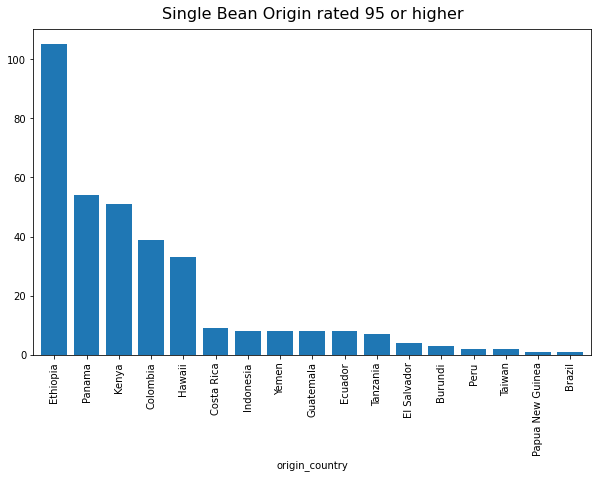

<Figure size 432x288 with 0 Axes>

In [18]:
def ratings(df, col, rating):
    df = df.loc[df["rating"] >=rating, :]
    countries = df.groupby(col)["rating"].count()
    
    plt.figure(figsize=(10,6))
    countries.sort_values(ascending=False).plot.bar(width = 0.8)
    plt.title(f"Single Bean Origin rated {rating} or higher", size=16, pad=10)
    plt.show();
    


ratings(coffee_single, "origin_country", 95)
plt.savefig('../chart/ratings_95.png', bbox_inches='tight')

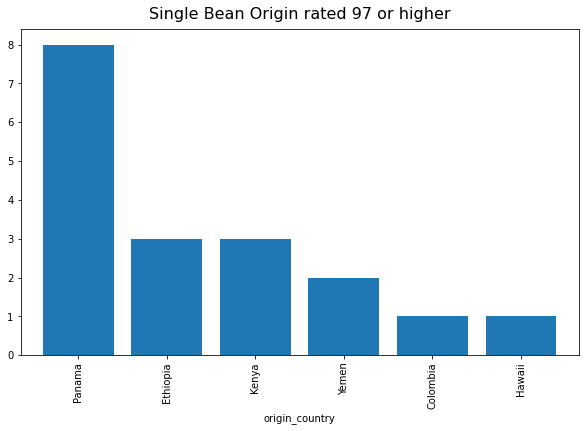

<Figure size 432x288 with 0 Axes>

In [19]:
ratings(coffee_single, "origin_country", 97)
plt.savefig('../chart/ratings_97.png', bbox_inches='tight')

In [20]:
rating_roast = coffee.loc[:,['rating','roast','agtron_bean']]
# df.loc[df["rating"] >=rating, :]

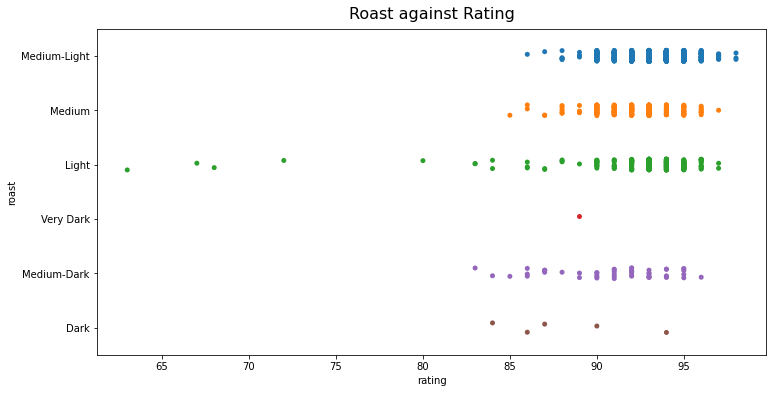

In [21]:
plt.figure(figsize=(12,6))
ax = plt.gca()
sns.stripplot(data=rating_roast, x='rating', y='roast', ax=ax)
# sns.stripplot(data=rating_roast, x='rating', y='body', ax=ax[1])
# 'aroma','acid','body','flavor','aftertaste','with_milk'
plt.title(f"Roast against Rating", size=16, pad=10)
plt.savefig('../chart/roast.png', bbox_inches='tight')

In [22]:
coffee.iloc[:, -4:].head(2)

,with_milk,desc_1,desc_2,desc_3
0,9.0,"Evaluated as espresso. Sweet-toned, deep...",An espresso blend comprised of coffees f...,A radiant espresso blend that shines equ...
1,9.0,"Evaluated as espresso. Sweetly tart, flo...",An espresso blend comprised of coffees f...,"A floral-driven straight shot, amplified..."


In [23]:
coffee['desc_3'] = coffee['desc_3'].fillna('')

In [24]:
coffee['desc'] = coffee['desc_1'] + ' ' + coffee['desc_3']

In [25]:
coffee['desc'] = coffee['desc'].str.strip()

In [26]:
new_stopwords = ["cup"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

In [27]:
cv = CountVectorizer(stop_words=stpwrd)
cv.fit(coffee['desc'])

coffee_cv = cv.transform(coffee['desc'])
coffee_cv_df = pd.DataFrame(coffee_cv.todense(), columns=cv.get_feature_names())

In [28]:
coffee_top_words = pd.DataFrame(coffee_cv_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
coffee_top_words

,Count
sweet,3596
toned,2903
mouthfeel,2299
finish,2283
aroma,2275
chocolate,2257
notes,2080
structure,1838
acidity,1836
fruit,1631


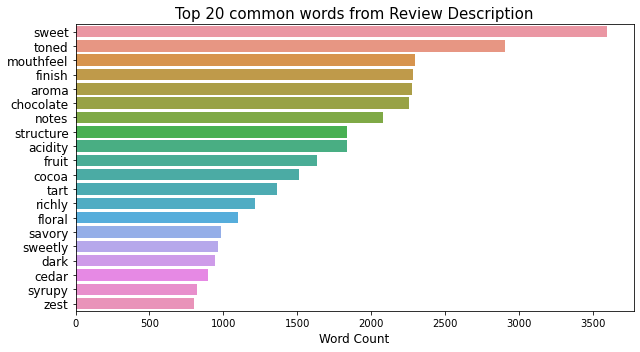

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(x='Count', y=coffee_top_words.index , data=coffee_top_words)
plt.title('Top 20 common words from Review Description',fontsize=15)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('../chart/coffee_20words.png', bbox_inches='tight')

In [30]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words=stpwrd)
cv_bigrams.fit(coffee['desc'])

coffee_bigrams_cv = cv_bigrams.transform(coffee['desc'])
coffee_bigrams_df = pd.DataFrame(coffee_bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

In [31]:
coffee_top_bi = pd.DataFrame(coffee_bigrams_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
coffee_top_bi

,Count
dark chocolate,857
aroma sweet,816
sweet tart,645
cocoa nib,620
syrupy mouthfeel,556
smooth mouthfeel,551
tart structure,548
richly sweet,544
mouthfeel finish,495
sweet savory,459


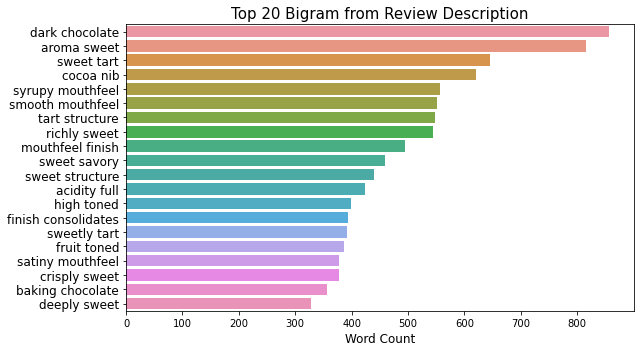

In [32]:
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(x='Count', y=coffee_top_bi.index , data=coffee_top_bi)
plt.title('Top 20 Bigram from Review Description',fontsize=15)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('../chart/coffee_bigram.png', bbox_inches='tight')

In [33]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words=stpwrd)
cv_trigrams.fit(coffee['desc'])

coffee_trigrams_cv = cv_trigrams.transform(coffee['desc'])
coffee_trigrams_df = pd.DataFrame(coffee_trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

In [34]:
coffee_top_tri = pd.DataFrame(coffee_trigrams_df.sum().sort_values(ascending=False).head(20), columns = ['Count'])
coffee_top_tri

,Count
sweet tart structure,315
three parts milk,247
aroma sweet structure,236
mouthfeel finish consolidates,234
aroma sweet tart,234
finish centers around,228
acidity full syrupy,226
finish consolidates notes,223
structure brisk acidity,218
aroma sweetly tart,214


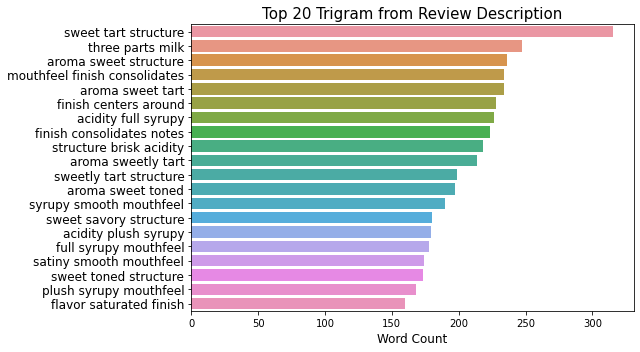

In [35]:
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(x='Count', y=coffee_top_tri.index , data=coffee_top_tri)
plt.title('Top 20 Trigram from Review Description',fontsize=15)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('../chart/coffee_trigram.png', bbox_inches='tight')

In [36]:
coffee_name = coffee.groupby(["name", "roast"]).size().sort_values(ascending=False).unstack().fillna(0)

In [37]:
coffee_name

roast,Dark,Light,Medium,Medium-Dark,Medium-Light,Very Dark
name,,,,,,
#She_Builds,0.0,0.0,0.0,0.0,1.0,0.0
100% Arabica Freeze-Dried Colombian (Instant Coffee),0.0,1.0,0.0,0.0,0.0,0.0
100% Guatemalan,0.0,0.0,0.0,1.0,0.0,0.0
100% Kona Bourbon,0.0,0.0,0.0,0.0,1.0,0.0
100% Kona Bourbon Pointu Laurina,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...
“Flowery” Espresso Blend,0.0,0.0,0.0,0.0,1.0,0.0
“Fruity” Espresso Blend,0.0,0.0,0.0,0.0,1.0,0.0
“Naturals”,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
origin_name = coffee.groupby(["origin_country", "roast"]).size().sort_values(ascending=False).unstack().fillna(0)
origin_name

roast,Dark,Light,Medium,Medium-Dark,Medium-Light,Very Dark
origin_country,,,,,,
Africa,0.0,1.0,0.0,0.0,1.0,0.0
Africa; Asia,0.0,0.0,0.0,0.0,1.0,0.0
Africa; Asia Pacific,0.0,0.0,0.0,0.0,1.0,0.0
Africa; Central America,0.0,0.0,1.0,0.0,1.0,0.0
Africa; Indonesia; South America,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
Thailand; Vietnam; Latin America,0.0,0.0,0.0,0.0,1.0,0.0
Uganda,0.0,0.0,1.0,0.0,3.0,0.0
Vietnam,0.0,0.0,0.0,0.0,3.0,0.0
